<a href="https://colab.research.google.com/github/brauliosba/Machine-Learning---TA2/blob/main/TB2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network

La red implementada en este colab puede ser aplicada para la virtualización de números escritos a mano. El dataset empleado fue el conjunto de entrnamiendo de Digit Recognizer, disponible en https://www.kaggle.com/c/digit-recognizer/data?select=train.csv.

In [240]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [241]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [242]:
n_epochs = 10

In [243]:
path = "/content/drive/My Drive/Machine Learning/Datasets/train.csv"

In [244]:
data_set = pd.read_csv(path)
print(data_set.shape)

(42000, 785)


In [245]:
# separando el dataset en pixeles y labels
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# liberando memoria
del data_set

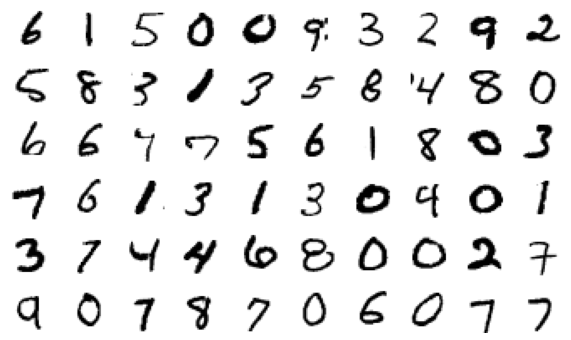

In [246]:
# muestra aleatoria de imagenes
fig, axs = plt.subplots(6, 10, figsize=(10, 6)) # 6 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [247]:
# normalizando los valores en rango 0 a 1
X = X / 255.0

In [248]:
# reshape de imagenes
img_size = 28
X_cnn = X.values.reshape(-1, img_size, img_size, 1)
# revisión
print(X_cnn.shape)

(42000, 28, 28, 1)


In [269]:
#creación del dataset de entrenamiento y test
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size = validation_ratio)

In [270]:
cnn = Sequential()
    
cnn.add(Conv2D(28, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1))) 
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())         
cnn.add(Dense(64, activation='sigmoid'))
cnn.add(Dropout(rate=0.1)) 
cnn.add(Dense(10, activation='softmax'))
    
cnn.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

cnn.summary()

Model: "sequential_570"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 4732)              0         
_________________________________________________________________
dense_607 (Dense)            (None, 64)                302912    
_________________________________________________________________
dropout_566 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_608 (Dense)            (None, 10)                650       
Total params: 303,842
Trainable params: 303,842
Non-trainable params: 0
______________________________________________

In [271]:
# entrenamiento y validación del modelo
history = cnn.fit(
    X_train_cnn,
    to_categorical(y_train_cnn),
    epochs=n_epochs,  
    validation_data=(X_test_cnn, to_categorical(y_test_cnn)), 
    batch_size=32
)

Epoch 1/10
1182/1182 [==============================] - 19s 16ms/step - loss: 0.3639 - accuracy: 0.9060 - val_loss: 0.1426 - val_accuracy: 0.9633
Epoch 2/10
1182/1182 [==============================] - 19s 16ms/step - loss: 0.1213 - accuracy: 0.9658 - val_loss: 0.0877 - val_accuracy: 0.9760
Epoch 3/10
1182/1182 [==============================] - 20s 17ms/step - loss: 0.0794 - accuracy: 0.9781 - val_loss: 0.0671 - val_accuracy: 0.9810
Epoch 4/10
1182/1182 [==============================] - 21s 17ms/step - loss: 0.0592 - accuracy: 0.9834 - val_loss: 0.0589 - val_accuracy: 0.9829
Epoch 5/10
1182/1182 [==============================] - 19s 16ms/step - loss: 0.0469 - accuracy: 0.9862 - val_loss: 0.0557 - val_accuracy: 0.9838
Epoch 6/10
1182/1182 [==============================] - 19s 16ms/step - loss: 0.0365 - accuracy: 0.9894 - val_loss: 0.0482 - val_accuracy: 0.9845
Epoch 7/10
1182/1182 [==============================] - 20s 17ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 0.0511 -

In [272]:
# impresión de precisión, recall y f1-score
y_pred = cnn.predict(X_test_cnn, batch_size=32, verbose=1)
y_pred_cate = np.argmax(y_pred, axis=1)
print(classification_report(y_test_cnn, y_pred_cate))

132/132 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      0.99      1.00       469
           2       0.98      0.99      0.99       434
           3       0.99      0.99      0.99       437
           4       0.98      0.98      0.98       392
           5       0.99      0.98      0.99       371
           6       1.00      0.99      0.99       428
           7       0.99      0.98      0.99       448
           8       0.98      0.98      0.98       417
           9       0.96      0.99      0.98       398

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



In [263]:
# entrenamiento y test set para el mlp
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X, y, test_size = validation_ratio)

In [266]:
# definir modelo mlp 
mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(784,)))
mlp.add(Dense(64, activation='sigmoid'))  
mlp.add(Dense(10, activation='softmax'))

mlp.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

mlp.summary()

Model: "sequential_569"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_604 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_605 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_606 (Dense)            (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [267]:
# entrenamiento y validación del modelo
history = mlp.fit(
    X_train_mlp,
    to_categorical(y_train_mlp),
    epochs = n_epochs,  
    validation_data = (X_test_mlp, to_categorical(y_test_mlp)),
    batch_size = 32,
)

Epoch 1/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.4141 - accuracy: 0.8958 - val_loss: 0.1877 - val_accuracy: 0.9450
Epoch 2/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.1450 - accuracy: 0.9575 - val_loss: 0.1449 - val_accuracy: 0.9548
Epoch 3/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0953 - accuracy: 0.9714 - val_loss: 0.1079 - val_accuracy: 0.9690
Epoch 4/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0669 - accuracy: 0.9807 - val_loss: 0.0982 - val_accuracy: 0.9693
Epoch 5/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0497 - accuracy: 0.9851 - val_loss: 0.0947 - val_accuracy: 0.9717
Epoch 6/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0391 - accuracy: 0.9883 - val_loss: 0.0917 - val_accuracy: 0.9740
Epoch 7/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0288 - accuracy: 0.9916 - val_loss: 0.0966 - val_accuracy:

In [268]:
# impresión de precisión, recall y f1-score
y_pred = mlp.predict(X_test_mlp, batch_size=32, verbose=1)
y_pred_cate = np.argmax(y_pred, axis=1)
print(classification_report(y_test_mlp, y_pred_cate))

132/132 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       413
           1       0.99      0.99      0.99       471
           2       0.97      0.98      0.98       416
           3       0.97      0.97      0.97       444
           4       0.99      0.93      0.96       423
           5       0.98      0.98      0.98       377
           6       0.99      0.98      0.98       391
           7       0.97      0.99      0.98       450
           8       0.95      0.98      0.96       397
           9       0.95      0.96      0.96       418

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200

